In [50]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

import olympus
from olympus.scalarizers import Scalarizer
from olympus.datasets import Dataset

In [55]:
def num_eval_to_x(res, pd, dl, ee):
    num_evals = []
    for r in res:
        good_evals = r.index[(r['particle_diameter']<=np.log10(pd))&(r['drug_loading']>=dl)&(r['encap_efficiency']>=ee)].tolist()
        if not good_evals == []:
            num_evals.append(np.amin(good_evals)+1)
        else:
            num_evals.append(r.shape[0]) # budget evals
    return num_evals, np.mean(num_evals), np.median(num_evals), np.std(num_evals)

In [51]:
# load resulsts
raw_res_rand = pickle.load(open('../results/results_random.pkl', 'rb'))
# raw_res_bo   = pickle.load(open('../results/results_botorch.pkl', 'rb'))
raw_res_grid = pickle.load(open('../results/results_grid.pkl', 'rb'))
raw_res_bo_5 = pickle.load(open('../results/results_botorch_5_init.pkl', 'rb'))

print(len(raw_res_rand))
# print(len(raw_res_bo))
print(len(raw_res_grid))
print(len(raw_res_bo_5))

dataset = Dataset('lnp3')

scalarizer = Scalarizer(
        kind='Hypervolume',
        value_space=dataset.value_space,
        goals=['max', 'max', 'min'],
    )


def unpack_results(res):
    
    num_iter = res[0].shape[0]
    new_dfs = []
    
    for ix in range(len(res)):
        r = res[ix]
        scal = scalarizer.scalarize(
            r.loc[:, ['drug_loading', 'encap_efficiency', 'particle_diameter']].values
        )
        trace_best_ix = [np.argmin(scal[:i+1]) for i in range(len(scal))]
        trace0 = [r.loc[i, 'drug_loading'] for i in trace_best_ix]
        trace1 = [r.loc[i, 'encap_efficiency'] for i in trace_best_ix]
        trace2 = [r.loc[i, 'particle_diameter'] for i in trace_best_ix] 
        r['iter'] = np.arange(r.shape[0])+1
        r['repeat'] = ix
        r['best_drug_loading'] = trace0
        r['best_encap_efficiency'] = trace1
        r['best_particle_diameter'] = 10**np.array(trace2)
        new_dfs.append(r)
        
    return pd.concat(new_dfs, ignore_index=True)
        
        
res_rand = unpack_results(raw_res_rand)
# res_bo = unpack_results(raw_res_bo)
res_grid = unpack_results(raw_res_grid)
res_bo_5 = unpack_results(raw_res_bo_5)


50
50
16


In [56]:
pdi = 15
dl = 0.19
ee = 0.6
num_evals_rand, mean_rand, med_rand, _ = num_eval_to_x(raw_res_rand, pdi, dl, ee)
# num_evals_bo, mean_bo, med_bo, _ = num_eval_to_x(raw_res_bo, pdi, dl, ee)
num_evals_grid, mean_grid, med_grid, _ = num_eval_to_x(raw_res_grid, pdi, dl, ee)
num_evals_bo_5, mean_bo_5, med_bo_5, _ = num_eval_to_x(raw_res_bo_5, pdi, dl, ee)

num_evals_list = []
for n in num_evals_rand:
    num_evals_list.append({'method': 'rand', 'num_evals': n})
for n in num_evals_grid:
    num_evals_list.append({'method': 'grid', 'num_evals': n})
# for n in num_evals_bo:
#     num_evals_list.append({'method': 'bo', 'num_evals': n})
for n in num_evals_bo_5:
    num_evals_list.append({'method': 'bo_5', 'num_evals': n})


num_evals = pd.DataFrame(num_evals_list)

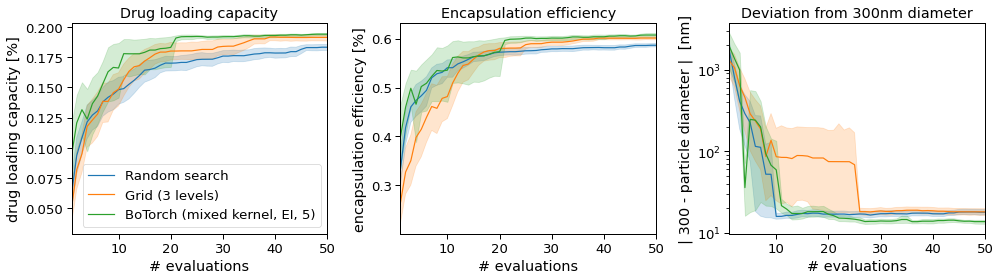

In [62]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4))

sns.lineplot(data=res_rand, x='iter', y='best_drug_loading', ax=ax0, label='Random search')
sns.lineplot(data=res_rand, x='iter', y='best_encap_efficiency', ax=ax1)
sns.lineplot(data=res_rand, x='iter', y='best_particle_diameter', ax=ax2)

sns.lineplot(data=res_grid, x='iter', y='best_drug_loading', ax=ax0, label='Grid (3 levels)')
sns.lineplot(data=res_grid, x='iter', y='best_encap_efficiency', ax=ax1)
sns.lineplot(data=res_grid, x='iter', y='best_particle_diameter', ax=ax2)


sns.lineplot(data=res_bo_5, x='iter', y='best_drug_loading', ax=ax0, label='BoTorch (mixed kernel, EI, 5)')
sns.lineplot(data=res_bo_5, x='iter', y='best_encap_efficiency', ax=ax1)
sns.lineplot(data=res_bo_5, x='iter', y='best_particle_diameter', ax=ax2)

# sns.lineplot(data=res_bo, x='iter', y='best_particle_diameter', ax=ax0, label='BoTorch (mixed kernel, EI, 10)')
# sns.lineplot(data=res_bo, x='iter', y='best_drug_loading', ax=ax1)

# sns.lineplot(data=res_bo_5, x='iter', y='best_particle_diameter', ax=ax0, label='BoTorch (mixed kernel, EI, 5)')
# sns.lineplot(data=res_bo_5, x='iter', y='best_drug_loading', ax=ax1)

# ax0.set_yscale('log')

ax0.set_title('Drug loading capacity')
ax1.set_title('Encapsulation efficiency')
ax2.set_title('Deviation from 300nm diameter')

ax2.set_yscale('log')
# ax0.set_ylim(0.9, 2.6)
# ax0.set_yscale('log')
# ax1.set_ylim(0.05, 0.205)
ax0.set_xlim(1, 50)
ax1.set_xlim(1, 50)
ax2.set_xlim(1, 50)

ax0.set_xlabel('# evaluations')
ax1.set_xlabel('# evaluations')
ax2.set_xlabel('# evaluations')

ax0.set_ylabel('drug loading capacity [%]')
ax1.set_ylabel('encapsulation efficiency [%]')
ax2.set_ylabel('| 300 - particle diameter |  [nm]')

# ax0.axvline(10, lw=2, ls=':', alpha=0.5, c='k')
# ax1.axvline(10, lw=2, ls=':', alpha=0.5, c='k')

plt.tight_layout()
plt.savefig('traces_three_objs.png', dpi=400)

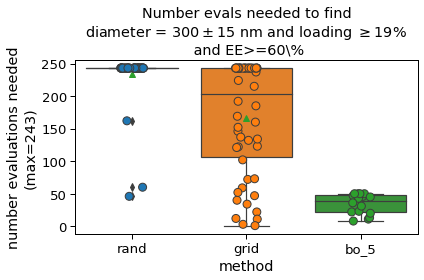

In [63]:
fig, ax0 = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(data=num_evals, x='method', y='num_evals', showmeans=True)
sns.stripplot(data=num_evals, x='method', y='num_evals', edgecolor='gray', linewidth=1, size=8)

ax0.set_ylabel('number evaluations needed\n(max=243)')
ax0.set_xlabel('method')

ax0.set_title(f'Number evals needed to find\n'+f'diameter = $300\pm15$ nm'+f' and loading $\geq 19\%$\n' ' and EE>=60\%')

plt.tight_layout()
plt.savefig('num_evals_needed_three_obj.png', dpi=400)

In [58]:
print(mean_bo_5, mean_grid, mean_rand)
print(med_bo_5, med_grid, med_rand)

34.0625 166.46 233.78
39.5 203.5 243.0


In [59]:
166.46/34.0625

4.8868990825688075

In [60]:
203.5/39.5

5.151898734177215

In [11]:
raw_res_bo_5[0]

,drug_input,solid_lipid,solid_lipid_input,liquid_lipid_input,surfractant_input,drug_loading,encap_efficiency,particle_diameter,iter,repeat,best_drug_loading,best_encap_efficiency,best_particle_diameter
0,10.709708158917884,Stearic_acid,88.04347817270389,26.48269160734501,0.006307678944350002,0.024203,0.253626,3.611714,1,0,0.024203,0.253626,4089.908076
1,22.185454330606056,Stearic_acid,115.36163229718667,32.734736336603156,0.00297475504713852,0.069583,0.348530,3.387481,2,0,0.069583,0.348530,2440.510728
2,32.28710017066207,Compritol_888,76.46861580501897,22.6874017819808,0.006948425961199006,0.145847,0.548992,1.186074,3,0,0.145847,0.548992,15.348791
3,30.909118767096658,Glyceryl_monostearate,105.79055437520174,45.76912221512403,0.00285249851299625,0.048105,0.228044,3.043749,4,0,0.145847,0.548992,15.348791
4,33.339268193304775,Stearic_acid,106.80092811887704,28.467422130534693,0.0019335304347111281,0.076190,0.378393,3.184507,5,0,0.145847,0.548992,15.348791
5,6.0,Compritol_888,119.99999772624562,48.0,0.0,0.002241,0.047535,1.115448,6,0,0.145847,0.548992,15.348791
6,43.44754932849366,Compritol_888,72.09069031676799,9.963198432601498,0.01,0.191469,0.592152,1.670191,7,0,0.191469,0.592152,46.794037
7,6.0,Compritol_888,72.00000000113909,48.0,0.0,0.002624,0.047714,1.430385,8,0,0.191469,0.592152,46.794037
8,6.0,Compritol_888,119.99999772624562,48.0,0.00932684302330017,0.018039,0.354462,1.246471,9,0,0.191469,0.592152,46.794037
9,6.0,Compritol_888,119.99999772624562,0.0,0.0,0.002906,0.049750,1.178419,10,0,0.191469,0.592152,46.794037
